# Figures from Assessing Correlated Truncation Errors in Modern Nucleon-Nucleon Potentials

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from scripts.generator_fns import *
import scipy

In [2]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

# Four-panel plots of total cross section ($\sigma_{\mathrm{tot}}$) coefficients

In [3]:
# sets colors
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]

In [4]:
# gets data for potential
pot = 'RKE_L-500MeV'
    
def get_data(observable_string):
    file_name = 'scattering_observables_RKE_L-500MeV.h5'
    dir_path = '../observables_data/'
    full_path = dir_path + file_name
    response = h5py.File(full_path, "r")
    obs_data = np.array(response[observable_string][:])
    response.close()
    return obs_data

SGT = get_data('SGT').T
DSG = get_data('DSG')
AY = get_data('PB')
A = get_data('A')
D = get_data('D')
AXX = get_data('AXX')
AYY = get_data('AYY')
t_lab = get_data('t_lab')
degrees = get_data('degrees')

# sets orders
if pot[:3] == 'RKE':
    orders = np.array([0, 2, 3, 4, 5, 6])
else:
    orders = np.array([0, 2, 3, 4, 5])

# calculates relative momentum from lab energy
p_rel = E_to_p(t_lab, interaction = 'np')

#### $m_{\mathrm{eff}} = 138\,\mathrm{MeV}$, $\Lambda_{b} = 600\,\mathrm{MeV}$

#### Fig. 1

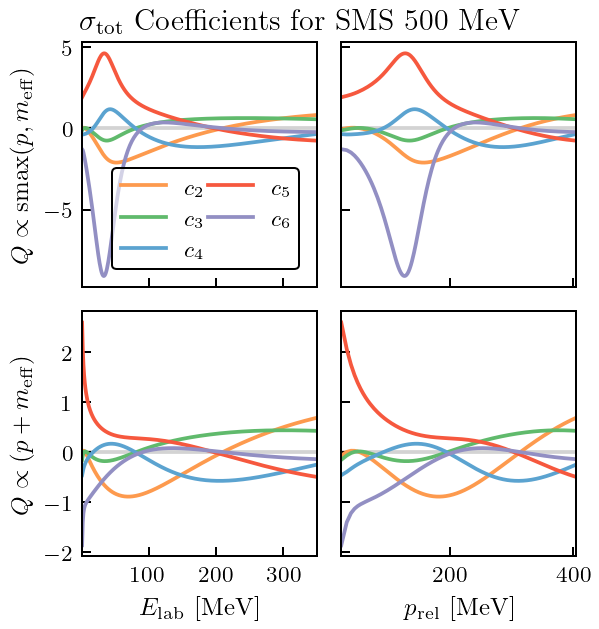

In [5]:
# sets breakdown and soft scales 
breakdown = 600
mpi = 138

# evaluates ratios
Q_max_p = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_max_E = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_s_p = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_s_E = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]

# evaluates coefficients
coeffs_sgt_max_p = gm.coefficients(SGT, ratio=Q_max_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_max_E = gm.coefficients(SGT, ratio=Q_max_E, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_p = gm.coefficients(SGT, ratio=Q_s_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_E = gm.coefficients(SGT, ratio=Q_s_E, ref=SGT[:, 0], orders=orders)[:, 1:]

coeffs_sgt = np.array([gm.coefficients(SGT, ratio=Q, ref=SGT[:, 0], orders=orders)[:, 1:] for Q in Q_list])

# plots
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(3.5,3.5))

for i, coeff in enumerate(np.swapaxes(np.swapaxes(coeffs_sgt, 0, 2), 1, 2)):
    axes[0, 0].plot(t_lab, coeff[0], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 0].plot(t_lab, coeff[2], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[0, 1].plot(p_rel, coeff[1], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 1].plot(p_rel, coeff[3], color=colors[i], label=f'$c_{orders[i+1]}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, color='lightgrey', zorder=-1)
axes[0, 0].legend(loc = "lower right", fontsize = 9, ncol = 2, columnspacing = 0.2)
axes[1, 0].set_xlabel(r'$E_{\rm lab}$ [MeV]', fontsize = 10)
axes[1, 1].set_xlabel(r'$p_{\rm rel}$ [MeV]', fontsize = 10)
axes[0, 0].set_ylabel(f'$Q \propto \mathrm{{smax}}(p, m_{{\mathrm{{eff}}}})$', fontsize = 10)
axes[1, 0].set_ylabel(f'$Q \propto (p + m_{{\mathrm{{eff}}}})$', fontsize = 10)
fig.tight_layout()
fig.suptitle(r'$\sigma_{\mathrm{tot}}$ Coefficients for SMS 500 MeV', 
             y=1.01, 
             fontsize = 12)
# saves
fig.savefig(f'sgt_coeff_assumption_grid_{pot}_mpi{mpi}.png')

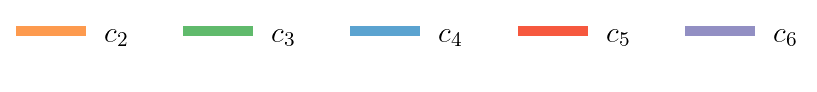

In [6]:
def export_legend(ax, filename="legend.png"):
    fig2 = plt.figure(figsize=(5, 0.5))
    ax2 = fig2.add_subplot()
    ax2.axis('off')
    legend = ax2.legend(*ax.get_legend_handles_labels(), 
                        frameon=False, loc='lower center', ncol=5, 
                       fontsize = 12)
    for i in range(5):
        legend.get_lines()[i].set_linewidth(4)
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
export_legend(axes[0, 0])

#### Figs. 5a, 6a

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


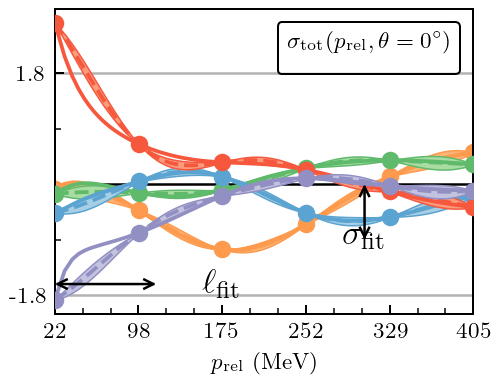

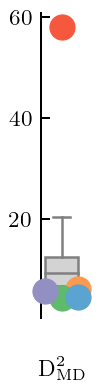

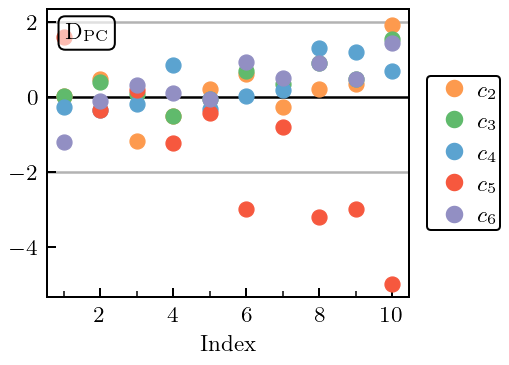

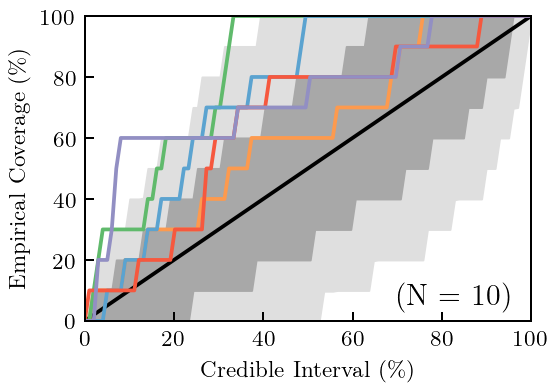

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


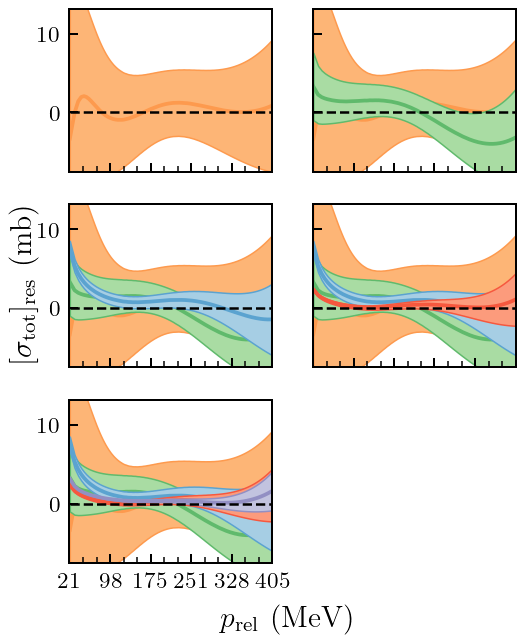

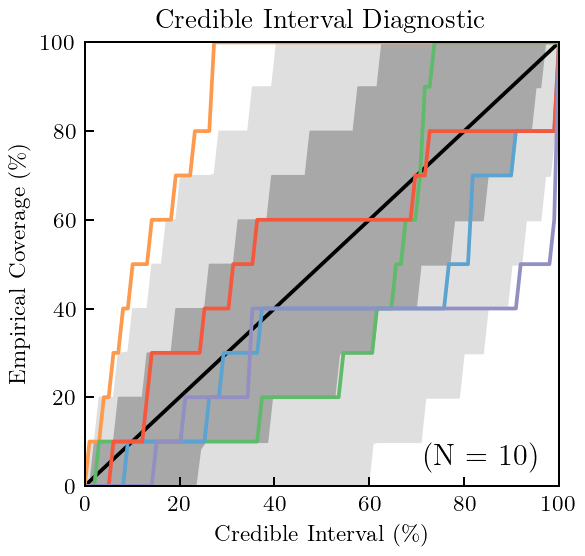

In [7]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["SGT"],
    x_quantities_array = [[], [0]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=600,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=True,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_mpi138",
)

#### $m_{\mathrm{eff}} = 200\,\mathrm{MeV}$, $\Lambda_{b} = 600\,\mathrm{MeV}$

#### Fig. 3

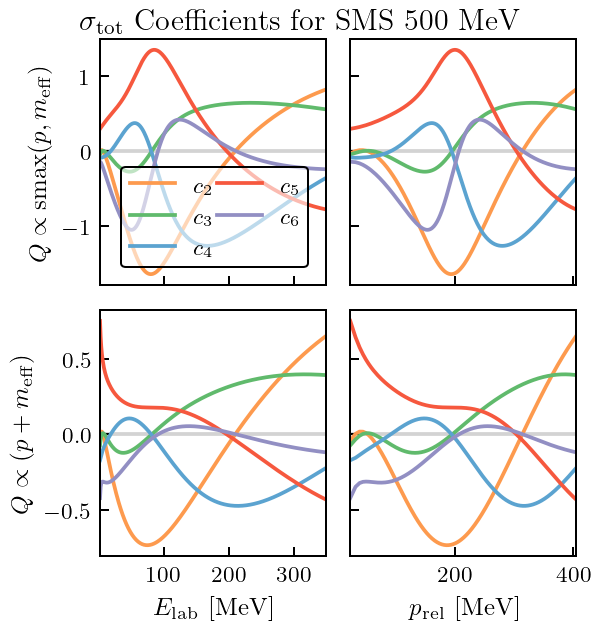

In [8]:
# sets breakdown and soft scales 
breakdown = 600
mpi = 200

# evaluates ratios
Q_max_p = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_max_E = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_s_p = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_s_E = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]

# evaluates coefficients
coeffs_sgt_max_p = gm.coefficients(SGT, ratio=Q_max_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_max_E = gm.coefficients(SGT, ratio=Q_max_E, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_p = gm.coefficients(SGT, ratio=Q_s_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_E = gm.coefficients(SGT, ratio=Q_s_E, ref=SGT[:, 0], orders=orders)[:, 1:]

coeffs_sgt = np.array([gm.coefficients(SGT, ratio=Q, ref=SGT[:, 0], orders=orders)[:, 1:] for Q in Q_list])

# plots
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(3.5,3.5))

for i, coeff in enumerate(np.swapaxes(np.swapaxes(coeffs_sgt, 0, 2), 1, 2)):
    axes[0, 0].plot(t_lab, coeff[0], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 0].plot(t_lab, coeff[2], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[0, 1].plot(p_rel, coeff[1], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 1].plot(p_rel, coeff[3], color=colors[i], label=f'$c_{orders[i+1]}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, color='lightgrey', zorder=-1)
axes[0, 0].legend(loc = "lower right", fontsize = 9, ncol = 2, columnspacing = 0.2)
axes[1, 0].set_xlabel(r'$E_{\rm lab}$ [MeV]', fontsize = 10)
axes[1, 1].set_xlabel(r'$p_{\rm rel}$ [MeV]', fontsize = 10)
axes[0, 0].set_ylabel(f'$Q \propto \mathrm{{smax}}(p, m_{{\mathrm{{eff}}}})$', fontsize = 10)
axes[1, 0].set_ylabel(f'$Q \propto (p + m_{{\mathrm{{eff}}}})$', fontsize = 10)
fig.tight_layout()
fig.suptitle(r'$\sigma_{\mathrm{tot}}$ Coefficients for SMS 500 MeV', 
             y=1.01, 
             fontsize = 12)
# saves
fig.savefig(f'sgt_coeff_assumption_grid_{pot}_mpi{mpi}.png')

#### Figs. 5b, 6b

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


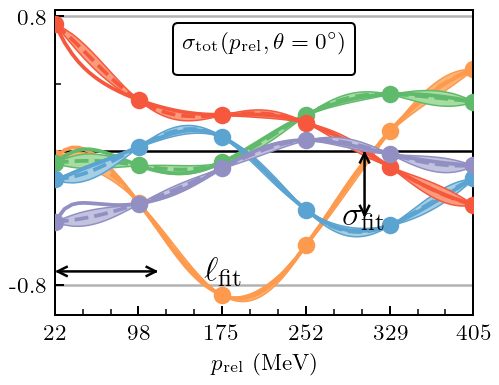

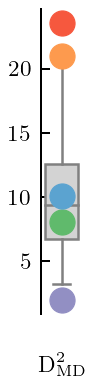

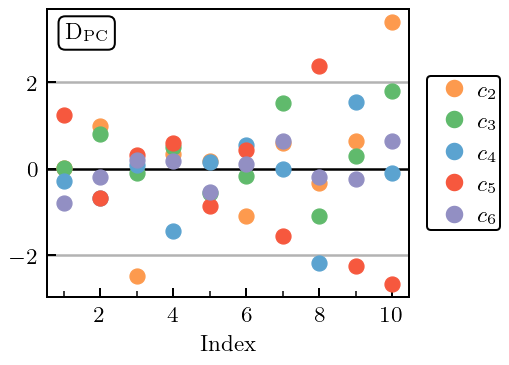

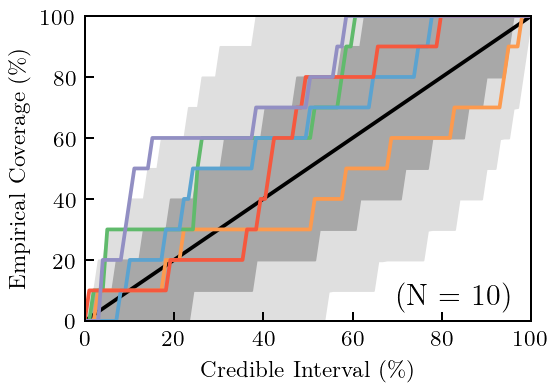

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


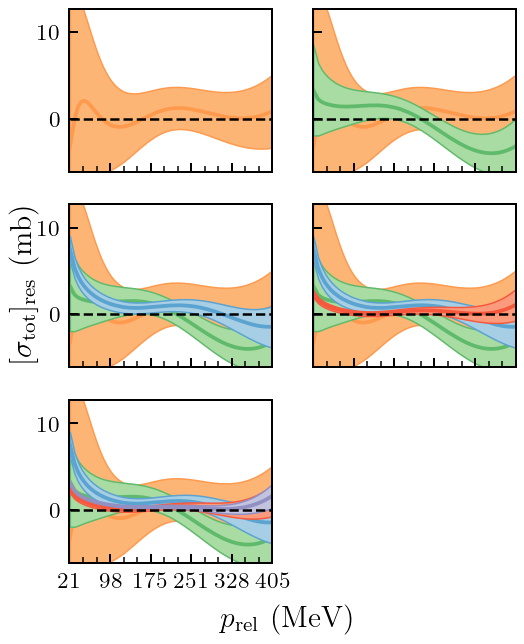

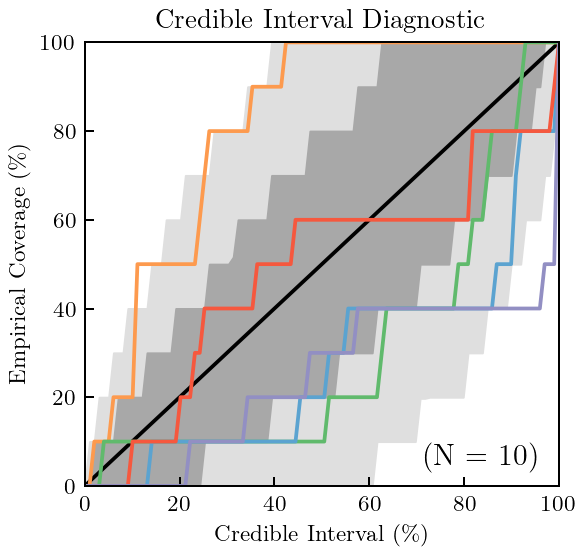

In [9]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["SGT"],
    x_quantities_array = [[], [0]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=200,
    Lambdab=600,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=True,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_mpi200",
)

In [10]:
1/0

ZeroDivisionError: division by zero

#### $m_{\mathrm{eff}}$ and $\Lambda_{b}$ set to optimal values (see code)

#### Fig. 8

In [ ]:
# evaluates ratios with optimal values of breakdown and soft scale for each combination of 
# Q parametrization and input space
# Q_max_E = Q_approx(p_rel, "smax", 460, m_pi = 158)
# Q_max_p = Q_approx(p_rel, "smax", 377, m_pi = 106)
# Q_s_E = Q_approx(p_rel, "sum", 517, m_pi = 189)
# Q_s_p = Q_approx(p_rel, "sum", 477, m_pi = 141)
# Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]
# Q_max_E = Q_approx(p_rel, "smax", 760, m_pi = 240)
Q_max_E = Q_approx(p_rel, "smax", 670, m_pi = 250)
Q_max_p = Q_approx(p_rel, "smax", 670, m_pi = 250)
# Q_s_E = Q_approx(p_rel, "sum", 1500, m_pi = 450)
Q_s_E = Q_approx(p_rel, "sum", 990, m_pi = 350)
Q_s_p = Q_approx(p_rel, "sum", 990, m_pi = 350)
Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]

# evaluates coefficients
coeffs_sgt_max_p = gm.coefficients(SGT, ratio=Q_max_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_max_E = gm.coefficients(SGT, ratio=Q_max_E, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_p = gm.coefficients(SGT, ratio=Q_s_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_E = gm.coefficients(SGT, ratio=Q_s_E, ref=SGT[:, 0], orders=orders)[:, 1:]

coeffs_sgt = np.array([gm.coefficients(SGT, ratio=Q, ref=SGT[:, 0], orders=orders)[:, 1:] for Q in Q_list])

# plots
fig, axes = plt.subplots(2, 2, 
                         sharex='col', 
                         sharey='row', 
                         figsize=(3.7,3.7))

for i, coeff in enumerate(np.swapaxes(np.swapaxes(coeffs_sgt, 0, 2), 1, 2)):
    axes[0, 0].plot(t_lab, coeff[0], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 0].plot(t_lab, coeff[2], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[0, 1].plot(p_rel, coeff[1], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 1].plot(p_rel, coeff[3], color=colors[i], label=f'$c_{orders[i+1]}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, color='lightgrey', zorder=-1)
axes[0, 0].legend(loc = "lower right", fontsize = 9, ncol = 2, columnspacing = 0.2)
axes[1, 0].set_xlabel(r'$E_{\rm lab}$ [MeV]', fontsize = 10)
axes[1, 1].set_xlabel(r'$p_{\rm rel}$ [MeV]', fontsize = 10)
axes[0, 0].set_ylabel(f'$Q \propto \mathrm{{smax}}(p, m_{{\mathrm{{eff}}}})$', fontsize = 10)
axes[1, 0].set_ylabel(f'$Q \propto (p + m_{{\mathrm{{eff}}}})$', fontsize = 10)
fig.tight_layout()
fig.suptitle(fr'$\sigma_{{\mathrm{{tot}}}}$ Coefficients for SMS 500 MeV', 
             y=1.01, fontsize = 12)
# saves
fig.savefig(f'sgt_coeff_assumption_grid_{pot}_mpiopt.png')

## Plot for all $Q$ prescriptions against $p_{\rm rel}$

#### Fig. 2

In [ ]:
Elab_array = np.linspace(0, 350, 351)

fig, ax = plt.subplots(figsize = (5.1, 3.8))

Lambdab = 600

ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "max", Lambda_b=Lambdab, m_pi = 138), 
        c = 'red', label = "max")
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "smax", Lambda_b=Lambdab, m_pi = 138), 
        c = 'green', label = "smoothmax")
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "sum", Lambda_b=Lambdab, m_pi = 138), 
        c = 'blue', label = r'sum')

axis_font = {'size':'13'}
ax.set_xlabel(r'$p_{\mathrm{rel}}$ [MeV]', **axis_font)
ax.set_ylabel(r'$Q$', **axis_font)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(loc = 'upper left', prop={'size': 12}, ncol = 1, columnspacing = 0.2)
fig.tight_layout()
fig.savefig('figures/Qparamvsprel.png')

## Evaluates the ratio $Q_{\rm sum} / Q_{\rm smax}$ over the relevant range in momentum and compares to a linear fit function

In [ ]:
def Qcomparison(prel, Lambda_b, mpi):
    return scipy.integrate.trapz(
            Q_approx(prel, "sum", 
                Lambda_b, 
                m_pi = mpi, 
                single_expansion = False), prel) / \
        scipy.integrate.trapz(
            Q_approx(prel, "smax", 
                Lambda_b, 
                m_pi = mpi, 
                single_expansion = False), prel)
            

Elab_array = np.linspace(1, 350, 350)
prel_array = E_to_p(Elab_array, 'np')
mpi_array = np.linspace(50, 350, 301)
mpi_array = mpi_array[mpi_array >= 100]

fig, ax = plt.subplots(figsize = (5.1, 3.8))

Lambdab = 600

ax.plot(mpi_array, [Qcomparison(prel_array, Lambdab, m) for m in mpi_array], 
        c = 'blue', label = r'$Q_{\mathrm{sum}}/Q_{\mathrm{smax}}$')
# ax.plot(mpi_array, Qsum_to_Qsmoothmax(mpi_array), 
#         c = 'orange', label = 'fitted')
ax.plot(mpi_array, 
        np.average([Qcomparison(prel_array, Lambdab, m) for m in mpi_array]) * np.ones(len(mpi_array)), 
        c = 'red', linestyle = (5, (10, 3)), label = r'average')
# ax.plot(mpi_array, 
#         1.6 * np.ones(len(mpi_array)), 
#         c = 'red', linestyle = (5, (10, 3)), label = r'$a_{\mathrm{sum}}$')

axis_font = {'size':'18'}
ax.set_xlabel(r'$m_{\mathrm{eff}}$ [MeV]', **axis_font)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc = 'lower right', prop={'size': 16}, ncol = 1, columnspacing = 0.2)
fig.tight_layout()
fig.savefig('figures/QsumQsmax.png')

## Plots $Q$ as a constant at different slices in momentum and fits to linear curve

#### Fig. 7

In [ ]:
# # fixed values of relative momentum where fitting will take place
# Elab_fit_pts = np.array([1, 5, 12, 21, 
#                          33, 48, 65, 85, 
#                          108, 133, 161, 192, 
#                          225, 261, 300, 341])
# prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

# # creates every object necessary to evaluate Q posteriors curvewise at fixed momentum
# ls_deg_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
# q_vals = np.linspace(0.01, 1.01, 100, dtype=np.dtype('f4'))

# mesh_cart_q = gm.cartesian(q_vals, np.log(ls_deg_vals))

# QVariable = RandomVariable(var=q_vals,
#                                 user_val=0.3,
#                                 name='Q',
#                                 label="Q",
#                                 units="",
#                                 ticks=[0.2, 0.4, 0.6, 0.8],
#                                 logprior=np.zeros(len(q_vals)),
#                                 logprior_name="noprior",
#                                 marg_bool=True)
# LsDegVariable = RandomVariable(var=ls_deg_vals,
#                                user_val=None,
#                                name='lsdeg',
#                                label="\ell_{\Theta}",
#                                units="",
#                                ticks=[],
#                                logprior=np.zeros(len(ls_deg_vals)),
#                                logprior_name="noprior",
#                                marg_bool=False)
# variables_array = np.array([QVariable, LsDegVariable])

# # ALLOBS for angle input spaces
# plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
# obs_name_grouped_list = ["ALLOBS"]
# obs_labels_grouped_list = [r'Obs.']
# mesh_cart_grouped_list = [[mesh_cart_q, mesh_cart_q, mesh_cart_q, mesh_cart_q,
#                            mesh_cart_q, mesh_cart_q]]

# ratio_fn = ratio_fn_constant
# ratio_fn_kwargs = {
#                   "Q" : 0.3
# }
# log_likelihood_fn = log_likelihood_const
# log_likelihood_fn_kwargs = {}

# Q_fit_pts = np.array([])
# Q_fit_stddev = np.array([])

# for elfp in Elab_fit_pts:
#     stats_array, _ = generate_posteriors(
#         scale_scheme_bunch_array=[RKE500MeV],
#         Q_param_method_array=["sum"],
#         p_param_method_array=["pprel"],
#         input_space_deg=["cos"],
#         input_space_tlab=["prel"],
#         Elab_slice = elfp,
#         t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
#         degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
#         orders_from_ho=1,
#         orders_excluded=[],
#         orders_names_dict=None,
#         orders_labels_dict=None,
#         length_scale_list = [NSKernelParam(0.4, [0.05, 3])],
#         m_pi_eff=141,
#         Lambdab=480,
#         print_all_classes=False,
#         savefile_type="png",

#         plot_posterior_curvewise_bool=True,
#         plot_corner_curvewise_bool=False,
#         use_data_curvewise_bool=False,
#         save_data_curvewise_bool=False,
#         save_posterior_curvewise_bool=False,

#         plot_obs_list = plot_obs_list,
#         obs_name_grouped_list = obs_name_grouped_list,
#         obs_labels_grouped_list = obs_labels_grouped_list,
#         mesh_cart_grouped_list = mesh_cart_grouped_list,
#         variables_array_curvewise = variables_array,
        
#         ratio_fn_posterior = ratio_fn,
#         ratio_fn_kwargs_posterior = ratio_fn_kwargs,
#         log_likelihood_fn_posterior = log_likelihood_fn,
#         log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

#         plot_posterior_pointwise_bool=False,
#         save_posterior_pointwise_bool=False,

#         variables_array_pointwise = np.array([0]),

#         filename_addendum="",
#     )
    
#     Q_fit_pts = np.append(Q_fit_pts, stats_array[0])
#     Q_fit_stddev = np.append(Q_fit_stddev, stats_array[2])

In [ ]:
# from sklearn.linear_model import LinearRegression

# fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))

# def q_sum(x, lambda_b, m_pi):
#     return (x + m_pi) / (m_pi + lambda_b)

# # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
# ax_fit.errorbar(prel_fit_pts, Q_fit_pts, yerr = 2 * Q_fit_stddev,
#                 color = 'tab:purple', label = r'$Q$ (pointwise)', fmt = 'o')
# # fits the points to a line
# popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, Q_fit_pts, 
#                                      sigma = Q_fit_stddev)
# # plots the line of best fit
# ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
#             q_sum(E_to_p(E_lab = t_lab, interaction = 'np'), popt[0], popt[1]), 
#             color = 'tab:purple')
# # prints the best fit values
# print("N4LO+: Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
# print("N4LO+: m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

# # plots Qsum(prel) with Lambda_b and m_pi values extracted from the total cross section posterior pdf
# ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
#            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
#                    Q_parametrization = 'sum', 
#                     Lambda_b = 990, 
#                     m_pi = 350), 
#             color = 'orange', label = r'$\sigma_{\mathrm{tot}}$')
# # plots Qsum(prel) with Lambda_b and m_pi values extracted from all the 2D observables' posterior pdf
# ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
#            Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
#                    Q_parametrization = 'sum', 
#                     Lambda_b = 570, 
#                     m_pi = 138), 
#             color = 'green', label = r'All 2D observables')

# # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
# ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 12)
# ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 12)
# ax_fit.legend(fontsize = 10, loc = 'upper left')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# fig_fit.tight_layout()

# fig_fit.savefig('figures/' + 'qvsp_linear')

## Plots graphical and statistical diagnostics for all figures in the paper

An earlier version of the code on which this notebook relies used `scipy.interpolate.interp1d` for interpolation when generating the following figures; in order to facilitate the generation of graphical and statistical diagnostics in two dimensions, `interp1d` was replaced by the more versatile `scipy.interpolate.griddata`, which resulted in noticeable _though not in any way consequential_ differences in the resulting figures when compared to those in the paper "Assessing Correlated Truncation Errors in Modern Nucleon-Nucleon Potentials". The figures here are the most current and should be considered correct.

#### Fig. 10

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["smax"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=106,
    Lambdab=378,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 11

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Figs. 28, 26a

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


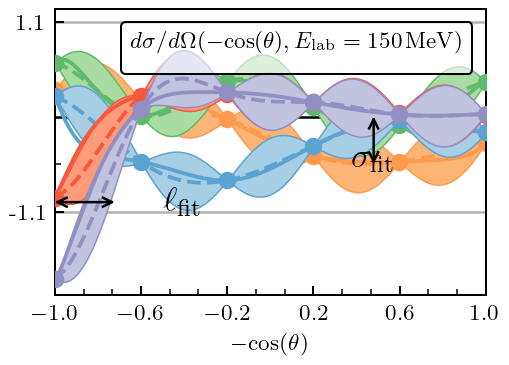

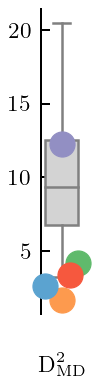

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1446: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


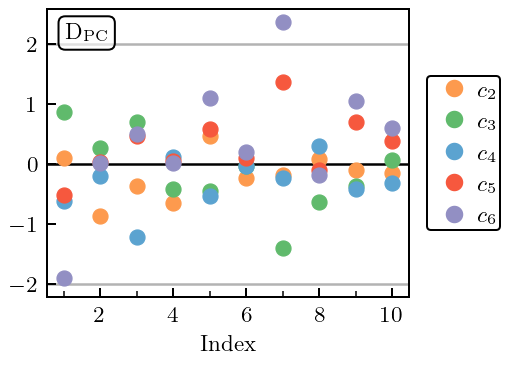

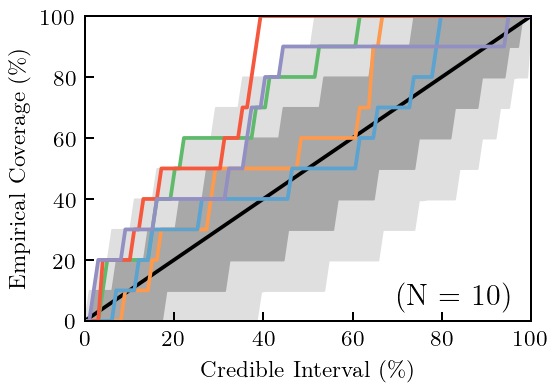

In [11]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofpq"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=172,
    Lambdab=660,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Figs. 12, 26b

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


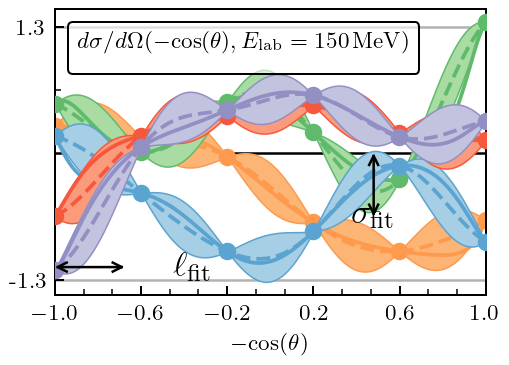

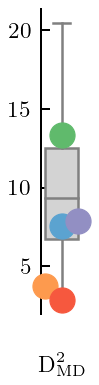

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1446: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


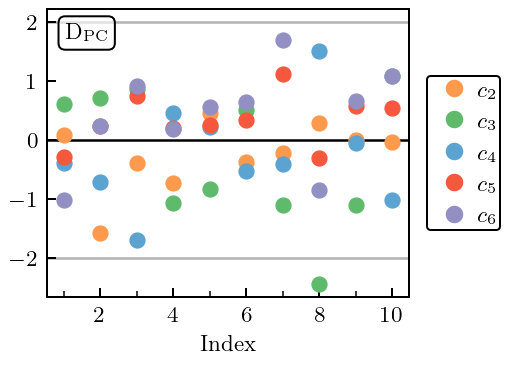

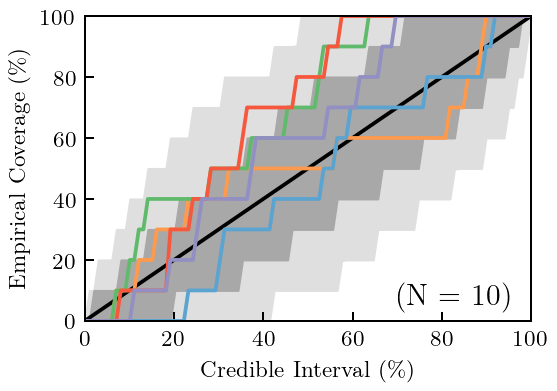

In [12]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 14

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["qcm"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=184,
    Lambdab=650,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 13

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Figs. 16, 27a

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(self.x_quantity_array)[
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1398: Vis

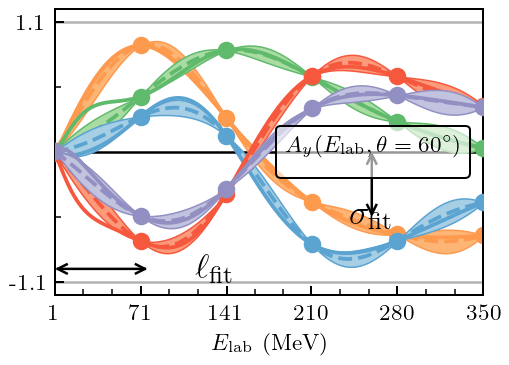

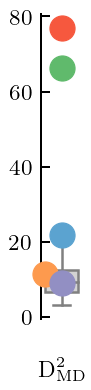

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1446: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(self.x_quantity_array)[


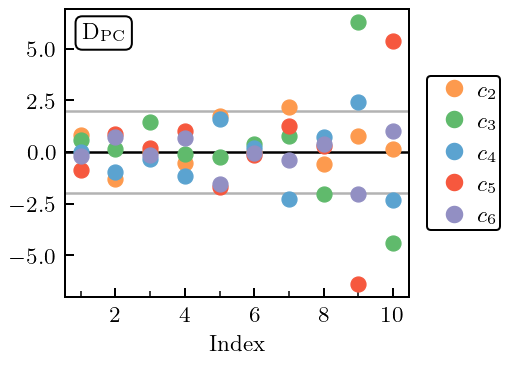

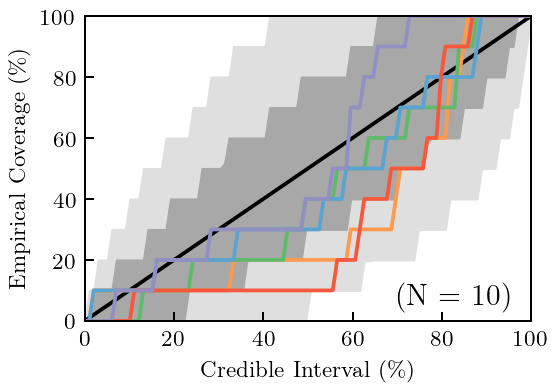

In [13]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["Elab"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=186,
    Lambdab=610,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Figs. 15, 27b

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(self.x_quantity_array)[
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1398: Vis

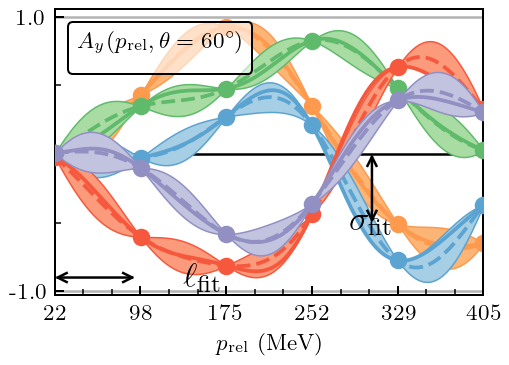

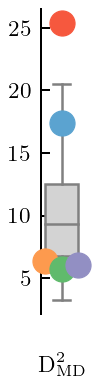

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1446: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(self.x_quantity_array)[


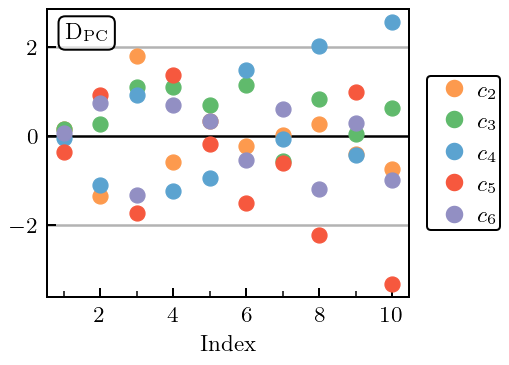

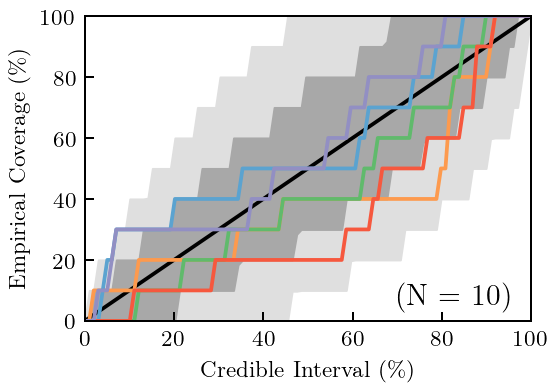

In [14]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 17

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AXX"],
    x_quantities_array = [[], [90]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 18

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AXX"],
    x_quantities_array = [[], [90]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Nolowenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 19

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["A"],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 20

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["A"],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Backwardanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 21

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["A"],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["deg"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=144,
    Lambdab=590,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 29

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
    x_quantities_array = [[200], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 30

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
    x_quantities_array = [[200], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Middleanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 31

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
    x_quantities_array = [[200], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["deg"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=144,
    Lambdab=590,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 22

In [ ]:
generate_diagnostics(
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D_dimensionful"],
    x_quantities_array = [[100], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis_badref",
)

#### Fig. 23

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
#     E_input_array=[100],
#     deg_input_array=[],
    x_quantities_array = [[100], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 32

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 33

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AXX"],
#     E_input_array=[150],
#     deg_input_array=[],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 24

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AYY"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis",
)

#### Fig. 25

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AYY"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[6],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=120,
    Lambdab=528,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=True,
    save_md_bool=True,
    save_pc_bool=True,
    save_ci_bool=True,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_thesis_noc6",
)

#### Fig. 9

In [ ]:
# create figure with n_orders subplots
fig_tlab_var_all_ratio, axs_tlab_var_all_ratio = plt.subplots(1, 1, 
                                                              figsize=(3.5,3.5))
axs_tlab_var_all_ratio.semilogy()

In [ ]:
# sets the potential of interest
ScaleScheme = RKE500MeV

# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
#                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
#                      interaction = "np")[:, None]
X_train_tlab = E_to_p(E_lab = np.array([1, 5, 12, 21, 33, 48, 65, 85, 108, 133, 161, 192, 225, 261, 300, 341]), 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
# t_lab_subset = t_lab_input[0::10]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
# X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
X_train_deg = -np.cos(np.radians(np.array([41, 60, 76, 90, 104, 120, 139])))[:, None]
degrees_label = "Negative cosine"

X_deg = degrees_input[:, None]
# degrees_subset = degrees_input[0::10]
degrees_subset = X_train_deg[:, 0]

Lambda_b_coeffs = 780
mpi_eff_coeffs = 240
# Lambda_b_coeffs = 570
# mpi_eff_coeffs = 138

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

In [ ]:
axs_tlab_var_all_array = np.array([])

# extracts data
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name in enumerate(obs_data_name_list):
    obs_data = ScaleScheme.get_data(obs_data_name)
    
    # sets reference scale
    if obs_data_name == "DSG":
        yref = obs_data[-1, :, :]
    else:
        yref = np.ones(np.shape(obs_data)[1:])

    # extracts coefficients
    coeffs_flattened = gm.coefficients(
                np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
                ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
                ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#     axs_tlab_var_all_array = np.array([])

    # plots at each energy in mesh
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
#         axs_tlab_var_all.scatter(t, 
#                     underlying_std, 
#     #                 c = 'green')
#                     c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

In [ ]:
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, :]) / np.min(axs_tlab_var_all_array[l, :]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 'o', 
    edgecolors = 'red',
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 25\,\mathrm{MeV}, m_{\pi}^{\star}, \Lambda_{b}^{\star})$',
#     edgecolors = 'green', 
#     label = r'2D ALLOBS, all $p_{\mathrm{rel}} > 25\,\mathrm{MeV}$',
    linewidths = 2,
    s = 90, 
    facecolors = 'none')
# axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
#     [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
#     marker = 's', 
# #     c = 'red', 
# #     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
#     c = 'green', 
#     label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
#     s = 90)
# axs_tlab_var_all_ratio.legend(loc = 'upper right', 
#                               fontsize = 10,
#                               handletextpad=0.02,
#                               borderpad=0.2)

# axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
# axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
# axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
# axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
# fig_tlab_var_all_ratio.savefig('figures/' + "var_ratios")

In [ ]:
Lambda_b_coeffs = 570
mpi_eff_coeffs = 138

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

In [ ]:
axs_tlab_var_all_array = np.array([])

# extracts data
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name in enumerate(obs_data_name_list):
    obs_data = ScaleScheme.get_data(obs_data_name)
    
    # sets reference scale
    if obs_data_name == "DSG":
        yref = obs_data[-1, :, :]
    else:
        yref = np.ones(np.shape(obs_data)[1:])

    # extracts coefficients
    coeffs_flattened = gm.coefficients(
                np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
                ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
                ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#     axs_tlab_var_all_array = np.array([])

    # plots at each energy in mesh
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
#         axs_tlab_var_all.scatter(t, 
#                     underlying_std, 
#     #                 c = 'green')
#                     c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

In [ ]:
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 's', 
#     c = 'red', 
#     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
    c = 'green', 
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
    s = 90)

axs_tlab_var_all_ratio.legend(loc = 'upper right', 
                              fontsize = 10,
                              handletextpad=0.02,
                              borderpad=0.2)

axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
fig_tlab_var_all_ratio.savefig('figures/' + "var_ratios")